In [1]:
import numpy as np
import json
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from numpy import unique
from numpy import where
import math
import csv
import copy
from collections import namedtuple

from funky_lights import wavefront, led_config

In [2]:
def PCA(data):
    # Calculate the mean of the points, i.e. the 'center' of the cloud
    datamean = data.mean(axis=0)
    # print('mean ' + str(datamean))

    # PCA to generate a line representation for each tube
    mu = data.mean(0)
    C = np.cov(data - mu, rowvar=False)
    d, u = np.linalg.eigh(C)
    U = u.T[::-1]

    # Project points onto the principle axes
    Z = np.dot(data - mu, U.T)
    # print('min Z ' + str(Z.min()))
    # print('max Z ' + str(Z.max()))

    return Z, U, mu


In [3]:
def cluster(data, eps, min_samples):
    model = DBSCAN(eps=eps, min_samples=min_samples)

    # fit model and predict clusters
    labels = model.fit_predict(data)

    # retrieve unique clusters
    clusters = unique(labels)

    if False:
        x2 = Z.T[0]
        y2 = Z.T[1]

        # create scatter plot for samples from each cluster
        for cluster in clusters:
            # get row indexes for samples with this cluster
            row_ix = where(labels == cluster)
            # create scatter of these samples
            plt.scatter(x2[row_ix], y2[row_ix], s=3)
        # show the plot
        plt.rcParams['figure.figsize'] = [25, 5]
        plt.axis('scaled')
        plt.show()
    
    return clusters, labels


In [4]:
class Node:
    def __init__(self, p):
        self.p = p
        self.next = None

    def distance(self, other_node):
        return np.linalg.norm(self.p - other_node.p)


def createLineSegments(data, clusters, labels):
    # First create an unordered list of nodes, one per cluster with using the mean of the cluster points.
    nodes = []
    for cluster in clusters:
        if cluster < 0: 
            continue
        row_ix = where(labels == cluster)
        cluster_points = data[row_ix]
        node = Node(p=cluster_points.mean(axis=0))
        nodes.append(node)
    if len(nodes) == 0: 
        return None

    # Connect nodes to line segments starting from a random node and extending in both directions the result is a start and an end node connected in a linked list
    start = nodes.pop()
    end = start
    while len(nodes) > 0:
        min_node = None
        min_dist = float('inf')
        closest_to_start = True

        for node in nodes:
            start_dist = start.distance(node)
            end_dist = end.distance(node)

            if start_dist < min_dist and start_dist <= end_dist:
                min_dist = start_dist
                min_node = node
                closest_to_start = True

            if end_dist < min_dist and end_dist < start_dist:
                min_dist = end_dist
                min_node = node
                closest_to_start = False

        if closest_to_start:
            min_node.next = start
            start = min_node
        else:
            end.next = min_node
            end = min_node

        nodes.remove(min_node)

    return start


def lineSegmentsLength(start):
    n = start
    total_length = 0
    while True:
        if n.next == None:
            break
        total_length = total_length + n.distance(n.next)
        n = n.next
    return total_length

# Generate LED positions by tracing along the line segments until the correct number of LED are created
def traceLineSegments(start, num_leds, offset, led_dist):
    segment_points = []
    fraction = 0
    n = start
    dist = offset
    for i in range(num_leds):
        new_fraction = fraction + dist / n.distance(n.next)
        while new_fraction >= 1:
            # Move to next segment
            dist = dist - (1 - fraction) * n.distance(n.next)
            n = n.next
            fraction = 0
            new_fraction = dist / n.distance(n.next)

        fraction = new_fraction
        p = n.p + fraction * (n.next.p - n.p)
        segment_points.append(p)
        dist = led_dist

    return np.array(segment_points)

def generateLEDPositions(data, clusters, labels, start_offset, end_offset, leds_per_meter):
    leds_distance = 1 / leds_per_meter
    segments = createLineSegments(data, clusters, labels)
    if segments == None:
        return [], 0
    length = lineSegmentsLength(segments)
    length = length - start_offset - end_offset
    num_leds = math.floor(length * leds_per_meter)
    points = traceLineSegments(segments, num_leds, start_offset, leds_distance)
    return points, length


In [5]:
def prepareData(group):
    x = np.array([v[0] for v in group.vertices])
    y = np.array([v[1] for v in group.vertices])
    z = np.array([v[2] for v in group.vertices])

    data = np.concatenate((x[:, np.newaxis],
                        y[:, np.newaxis],
                        z[:, np.newaxis]),
                        axis=1)
    return data

In [6]:
def plotSegment(data, clusters, labels, segment_points):
    Z, U, mu = PCA(data)
    x2 = Z.T[0]
    y2 = Z.T[1]

    # create scatter plot for samples from each cluster
    for cluster in clusters:
        # get row indexes for samples with this cluster
        row_ix = where(labels == cluster)
        # create scatter of these samples
        plt.scatter(x2[row_ix], y2[row_ix], s=3)

    # # create scatter plot for line segments
    # print('U ' + str(U))
    L = np.dot(segment_points - mu, U.T)
    xl2 = L.T[0]
    yl2 = L.T[1]
    plt.scatter(xl2, yl2, s=3)

    plt.axis('scaled')
    plt.show()
    plt.rcParams['figure.figsize'] = [25, 5]

In [7]:
def project2D(data):
    Z, U, mu = PCA(data)
    return np.dot(data - mu, U.T)[:,:2]

Segment dome/center: length=7.1m, num_clusters=32, num_leds=214


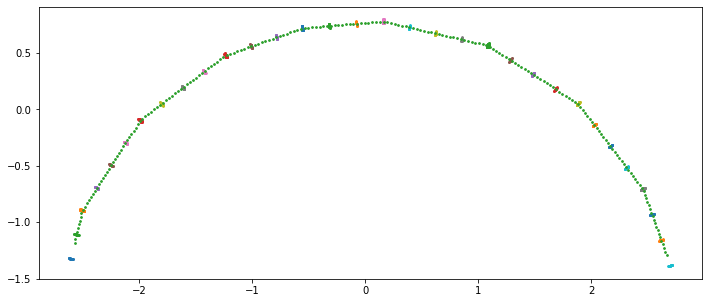

Segment dome/left: length=6.8m, num_clusters=43, num_leds=205


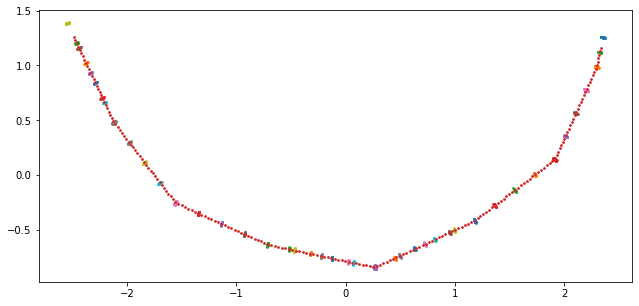

Segment dome/right: length=6.8m, num_clusters=43, num_leds=205


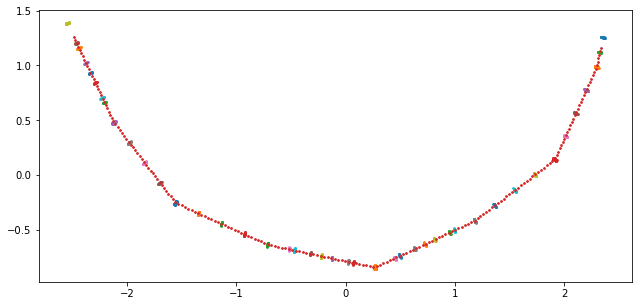

Segment trunk/Body1: length=5.0m, num_clusters=454, num_leds=150


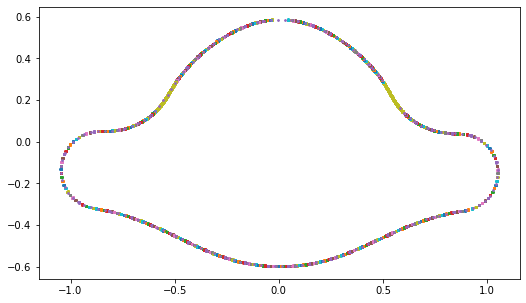

Segment trunk/Body2: length=3.3m, num_clusters=281, num_leds=98


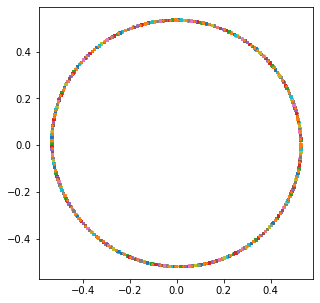

Segment trunk/Body3: length=3.0m, num_clusters=293, num_leds=91


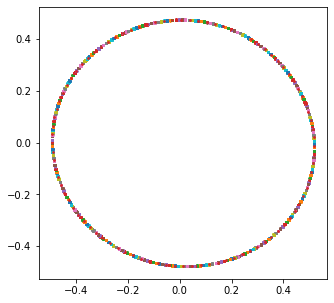

Segment trunk/Body4: length=2.8m, num_clusters=259, num_leds=85


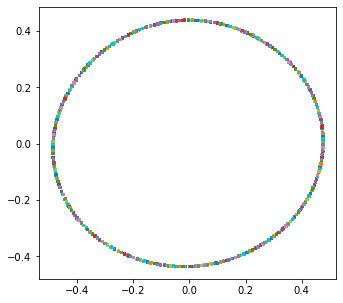

Segment trunk/Body5: length=2.6m, num_clusters=251, num_leds=79


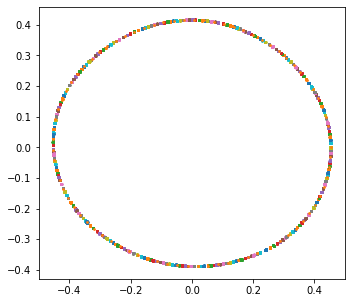

Segment trunk/Body6: length=2.4m, num_clusters=217, num_leds=73


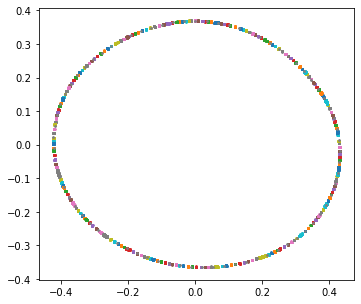

Segment trunk/Body7: length=2.2m, num_clusters=204, num_leds=67


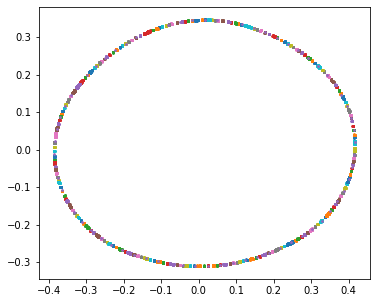

Segment trunk/Body8: length=2.0m, num_clusters=157, num_leds=61


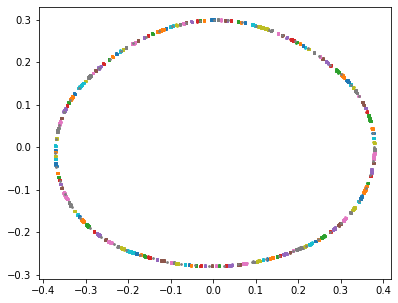

Segment trunk/Body9: length=1.9m, num_clusters=144, num_leds=56


In [16]:
MeshConfig = namedtuple(
    'MeshConfig', ['mesh', 'cluster_eps', 'start_offset', 'end_offset', 'uid_offset', 'output_json', 'output_csv'])

mesh_configs = [
    MeshConfig(
        mesh='../controller/mesh/dome.obj',
        cluster_eps=0.03,
        start_offset=0.10,
        end_offset=0.10,
        uid_offset=0,
        output_json='../config/dome.json',
        output_csv='../config/dome.csv'
    ),
    MeshConfig(
        mesh='../controller/mesh/trunk.obj',
        cluster_eps=0.005,
        start_offset=0.01,
        end_offset=0.01,
        uid_offset=100,
        output_json='../config/trunk.json',
        output_csv='../config/trunk.csv'
    ),
    MeshConfig(
        mesh='../controller/mesh/head.obj',
        cluster_eps=0.03,
        start_offset=0.05,
        end_offset=0.05,
        uid_offset=150,
        output_json='../config/head.json',
        output_csv='../config/head.csv'
    ),
    MeshConfig(
        mesh='../controller/mesh/legs.obj',
        cluster_eps=0.03,
        start_offset=0.05,
        end_offset=0.05,
        uid_offset=200,
        output_json='../config/legs.json',
        output_csv='../config/legs.csv'
    )
]

all_segments = {}
for config in mesh_configs:
    uid = config.uid_offset + 1
    mesh = wavefront.load_obj(config.mesh)
    segments=[]
    for group in mesh.groups:
        data = prepareData(group)
        data_2d = project2D(data)
        clusters, labels = cluster(
            data_2d, eps=config.cluster_eps, min_samples=3)
        points, length = generateLEDPositions(
            data, clusters, labels, start_offset=config.start_offset, end_offset=config.end_offset, leds_per_meter=30)
        print('Segment %s: length=%.1fm, num_clusters=%s, num_leds=%s' %
              (group.name, length, len(clusters), len(points)))
        if len(points) == 0:
            continue
        segment = led_config.Segment(
            uid=uid, name=group.name, points=points, num_leds=points.shape[0], length=length)
        segments.append(segment)
        all_segments[uid] = segment
        # plotSegment(data, clusters, labels, points)
        uid += 1
    
    csv_header = ['uid', 'name', 'num_leds', 'length']
    csv_data = []
    for segment in segments:
        csv_data.append([segment.uid, segment.name, segment.num_leds,
                        '{:.2f}'.format(segment.length)])

    with open(config.output_csv, 'w', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(csv_header)
        for row in csv_data:
            writer.writerow(row)

In [ ]:
# Collapse some segments
UIDS_TRUNK = [101,102,103,104,105,106,107,108,109,110,111,112,113,114,115]
UIDS_TUSKS_RIGHT = [116,117,118,119,120,121,122,123,124,125,126]
UIDS_TUSKS_LEFT = [127,128,129,130,131,132,133,134,135,136,137]
for merge_list in [UIDS_TRUNK, UIDS_TUSKS_RIGHT, UIDS_TUSKS_LEFT]:
    merged_segment = all_segments[merge_list[0]]
    for uid in merge_list[1:]:
        segment = all_segments.pop(uid)
        merged_segment.merge(segment)

# Create LED config
config = led_config.LedConfig()
for segment in all_segments.values():
    config.led_segments.append(segment)
    config.total_num_segments += 1
    config.total_length += segment.length
    config.total_num_leds += segment.num_leds

with open('../config/led_config.json', 'w', encoding='utf-8') as f:
    json.dump(config.to_dict(), f, ensure_ascii=False, indent=4)
